In [1]:
%pylab inline

from scipy.ndimage.filters import convolve

import theano
import theano.tensor.signal.downsample
import skimage.io
print theano.config.floatX

from common.plotting import plot_mat

from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

Populating the interactive namespace from numpy and matplotlib
float32


Using gpu device 0: GeForce GTX 780 (CNMeM is enabled)


Each trainin batch consits of a tuple containing:
 - an array of size (125, 3, 32, 32) containing float32
 - an array of size (125, 1) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (100, 3, 32, 32) containing float32
 - an array of size (100, 1) containing uint8
320


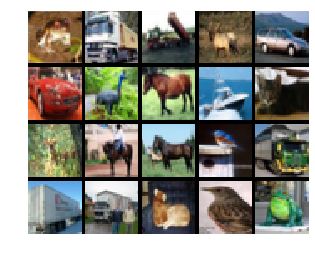

In [2]:
CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'})
)

cifar10_train = CIFAR10(("train",), subset=slice(None,40000))
cifar10_valid = CIFAR10(("train",), subset=slice(40000, None))
cifar10_testt  = CIFAR10(("test",))

minibatch_train = 125
minibatch_valid = 100
minibatch_testt = 100

cifar10_train_stream = DataStream.default_stream(
    cifar10_train,
    iteration_scheme=ShuffledScheme(cifar10_train.num_examples, minibatch_train)
)
cifar10_valid_stream = DataStream.default_stream(
    cifar10_valid, 
    iteration_scheme=SequentialScheme(cifar10_valid.num_examples, minibatch_valid)
)
cifar10_testt_stream = DataStream.default_stream(
    cifar10_testt, 
    iteration_scheme=SequentialScheme(cifar10_testt.num_examples, minibatch_testt)
)

print "Each trainin batch consits of a tuple containing:"
for element in next(cifar10_train_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
    
print "Validation/test batches consits of tuples containing:"
for element in next(cifar10_testt_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
    

plot_mat(cifar10_train.data_sources[0][:20], cmap='gray')

asd = 0
for x,y in cifar10_train_stream.get_epoch_iterator():
    asd += 1
print asd

In [3]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)

In [4]:
def print_warn(s, X):
    print "after_%s shape: %s" % (s, X.tag.test_value.shape,)

class Layer_Conv():
    def __init__(self, in_chan, out_chan, size):
        self.in_chan = in_chan
        self.out_chan = out_chan
        self.size = size
    def make(self, X, n):
        CWn = theano.shared(np.zeros((self.out_chan, self.in_chan, self.size, self.size), dtype='float32'), name=('CW%d'%n))
        CBn = theano.shared(np.zeros((self.out_chan,), dtype='float32'), name=('CB%d'%n))
        
        CWn.tag.initializer = IsotropicGaussian(0.05)
        CBn.tag.initializer = Constant(0.0)
        
        after_Cn = theano.tensor.maximum(
            0.0,
            theano.tensor.nnet.conv2d(X, CWn) + CBn.dimshuffle('x',0,'x','x')
        )
        print_warn(("C%d"%n), after_Cn)
        
        return after_Cn, [CWn, CBn], [("C%d"%n)]
    
class Layer_Pool():
    def __init__(self, size):
        self.size = size        
    def make(self, X, n):
        after_Pn = theano.tensor.signal.downsample.max_pool_2d(X, (self.size, self.size), ignore_border=True)
        print_warn(("P%d"%n), after_Pn)
        
        return after_Pn, [], [("P%d"%n)]
    
class Layer_Filt():
    def __init__(self, in_chan, out_chan):
        self.in_chan = in_chan
        self.out_chan = out_chan
    def make(self, X, n):
        FWn = theano.shared(np.zeros((self.in_chan, self.out_chan), dtype='float32'), name=('FW%d'%n))
        FBn = theano.shared(np.zeros((self.out_chan,), dtype='float32'), name=('FB%d'%n))
        
        FWn.tag.initializer = IsotropicGaussian(0.05)
        FBn.tag.initializer = Constant(0.0)

        after_Fn = theano.tensor.dot(X.flatten(2), FWn) + FBn.dimshuffle('x',0)
        print_warn(("F%d"%n), after_Fn)
        
        return after_Fn, [FWn, FBn], [("F%d"%n)]
    
class Layer_Soft():
    def __init__(self):
        pass
    def make(self, X, n):
        after_Sn = theano.tensor.nnet.softmax(X)
        print_warn(("S%d"%n), after_Sn)
        
        return after_Sn, [], [("S%d"%n)]
        

In [5]:
class NetworkBuilder():
    def __init__(self, layerlist):
        self.layers = layerlist
    def make(self, X):
        model_parameters = []
        self.model_names = ["X"]
        self.model_layers = [X] 
        i = 1
        after = X
        for layer in self.layers:
            after, param, name = layer.make(after, i)
            self.model_layers += [after]
            model_parameters += param
            self.model_names += name
            i += 1
            
        return after, model_parameters
            

In [6]:
theano.config.compute_test_value = 'warn'
X_test_value, Y_test_value = next(cifar10_train_stream.get_epoch_iterator())

X = theano.tensor.tensor4('X')
Y = theano.tensor.matrix('Y', dtype='uint8')
X.tag.test_value = X_test_value[:3]
Y.tag.test_value = Y_test_value[:3]
print "X shape: %s" % (X.tag.test_value.shape,)

network = NetworkBuilder([
        Layer_Conv(3, 40, 3),
        Layer_Pool(2),
        Layer_Conv(40, 60, 4),
        Layer_Pool(2),
        Layer_Conv(60, 90, 3),
        Layer_Filt(90*4*4, 1500),
        Layer_Filt(1500, 600),
        Layer_Filt(600, 10),
        Layer_Soft()
    ])

output, parameters = network.make(X)

predictions = theano.tensor.argmax(output, axis=1)

error_rate = theano.tensor.neq(predictions,Y.ravel()).mean()

nll = - theano.tensor.log(output[theano.tensor.arange(Y.shape[0]), Y.ravel()]).mean()

alpha = 3e-3
weight_decay = 0.0
for p in parameters:
    if p.name[1]=='W':
        weight_decay = weight_decay + alpha * (p**2).sum()

cost = nll + weight_decay

theano.config.compute_test_value = 'off'

X shape: (3, 3, 32, 32)
after_C1 shape: (3, 40, 30, 30)
after_P2 shape: (3, 40, 15, 15)
after_C3 shape: (3, 60, 12, 12)
after_P4 shape: (3, 60, 6, 6)
after_C5 shape: (3, 90, 4, 4)
after_F6 shape: (3, 1500)
after_F7 shape: (3, 600)
after_F8 shape: (3, 10)
after_S9 shape: (3, 10)


In [7]:
updates = []

lrate = theano.tensor.scalar('lrate',dtype='float32')
momentum = theano.tensor.scalar('momentum',dtype='float32')
gradients = theano.grad(cost, parameters)
velocities = [theano.shared(np.zeros_like(p.get_value()), name='V_%s' %(p.name, )) for p in parameters]

for p,g,v in zip(parameters, gradients, velocities):
    v_new = momentum * v - lrate * g
    p_new = p + v_new
    updates += [(v,v_new), (p, p_new)]

In [8]:
train_step = theano.function(
    [X, Y, lrate, momentum],
    [cost, error_rate, nll, weight_decay],
    updates=updates
)

predict = theano.function(
    [X], 
    predictions
)

In [9]:
def compute_error_rate(stream):
    errs = 0.0
    num_samples = 0.0
    for X, Y in stream.get_epoch_iterator():
        errs += (predict(X)!=Y.ravel()).sum()
        num_samples += Y.shape[0]
    return errs/num_samples

def compute_error_rate_with_write(stream, fo):
    errs = 0.0
    num_samples = 0.0
    for X, Y in stream.get_epoch_iterator():
        tempX = predict(X)
        tempY = Y.ravel()
        errs += (tempX!=tempY).sum()
        for xx,yy in zip(tempX, tempY):
            fo.write(str(xx)+' '+str(yy)+'\n')
        num_samples += Y.shape[0]
    return errs/num_samples

def init_parameters():
    rng = np.random.RandomState(1234)
    for p in parameters:
        p.set_value(p.tag.initializer.generate(rng, p.get_value().shape))

def snapshot_parameters():
    return [p.get_value(borrow=False) for p in parameters]

def load_parameters(snapshot):
    for p, s in zip(parameters, snapshot):
        p.set_value(s, borrow=False)
        
#Michal's Łowicki idea
def shift(X_batch):
    ret = X_batch
    for i in xrange(ret.shape[0]):
        ret[i] = np.roll(ret[i],np.random.randint(-4,4), axis=1)
        ret[i] = np.roll(ret[i],np.random.randint(-4,4), axis=2)
    return ret

In [10]:
import time

i=-1
e=0
startTotal = time.time()
init_parameters()
for v in velocities:
    v.set_value(np.zeros_like(v.get_value()))

best_valid_error_rate = np.inf
best_params = snapshot_parameters()
best_params_epoch = 0

train_erros = []
train_loss = []
train_nll = []
validation_errors = []

number_of_epochs = 3
patience_expansion = 1.5

while e<number_of_epochs:
    e += 1
    epoch_start_i = i
    
    startPart = time.time()
    for X_batch, Y_batch in cifar10_train_stream.get_epoch_iterator(): 
        i += 1
        
        K = 6400
        lrate = 8e-3 * K / np.maximum(K, i)
        momentum=0.9
        
        #L, err_rate, nll, wdec = train_step(X_batch, Y_batch, lrate, momentum)
        #
        #train_loss.append((i*2,L))
        #train_erros.append((i*2,err_rate))
        #train_nll.append((i*2,nll))
        
        X_batch_shift = shift(X_batch)
        
        L, err_rate, nll, wdec = train_step(X_batch_shift, Y_batch, lrate, momentum)
        
        #train_loss.append((i*2+1,L))
        #train_erros.append((i*2+1,err_rate))
        #train_nll.append((i*2+1,nll))
        train_loss.append((i,L))
        train_erros.append((i,err_rate))
        train_nll.append((i,nll))
        
        
        if i % 100 == 0:
            print "At minibatch %d, batch loss %f, batch nll %f, batch error rate %f%%" % (i, L, nll, err_rate*100)
    print "Epoch time:",(time.time()-startPart),"s"
        
    
    val_error_rate = compute_error_rate(cifar10_valid_stream)
    if val_error_rate < best_valid_error_rate:
        number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion+1)
        best_valid_error_rate = val_error_rate
        best_params = snapshot_parameters()
        best_params_epoch = e
        
    validation_errors.append((i,val_error_rate))
    print "After epoch %d: valid_err_rate: %f%% currently going to do %d epochs" %(
        e, val_error_rate*100, number_of_epochs)
    
    print "After epoch %d: averaged train_err_rate: %f%% averaged train nll: %f averaged train loss: %f" %(
        e, 
        np.mean(np.asarray(train_erros)[epoch_start_i:,1])*100, 
        np.mean(np.asarray(train_nll)[epoch_start_i:,1]),
        np.mean(np.asarray(train_loss)[epoch_start_i:,1])
    )
    
print "Total time:",(time.time()-startTotal)/60.0,"min"

At minibatch 0, batch loss 25.996986, batch nll 2.285613, batch error rate 81.600000%
At minibatch 100, batch loss 23.469429, batch nll 1.736900, batch error rate 66.400000%
At minibatch 200, batch loss 21.160496, batch nll 1.410242, batch error rate 50.400000%
At minibatch 300, batch loss 19.451056, batch nll 1.500643, batch error rate 56.000000%
Epoch time: 38.7679581642 s
After epoch 1: valid_err_rate: 48.460000% currently going to do 3 epochs
After epoch 1: averaged train_err_rate: 48.000000% averaged train nll: 1.349421 averaged train loss: 18.976551
At minibatch 400, batch loss 17.752729, batch nll 1.435799, batch error rate 48.000000%
At minibatch 500, batch loss 16.230873, batch nll 1.394371, batch error rate 54.400000%
At minibatch 600, batch loss 14.805134, batch nll 1.312617, batch error rate 46.400000%
Epoch time: 38.8824231625 s
After epoch 2: valid_err_rate: 42.340000% currently going to do 4 epochs
After epoch 2: averaged train_err_rate: 47.484112% averaged train nll: 1.

Setting network parameters from after epoch 465
Success rate is 81.660000%
Error rate is 18.340000%


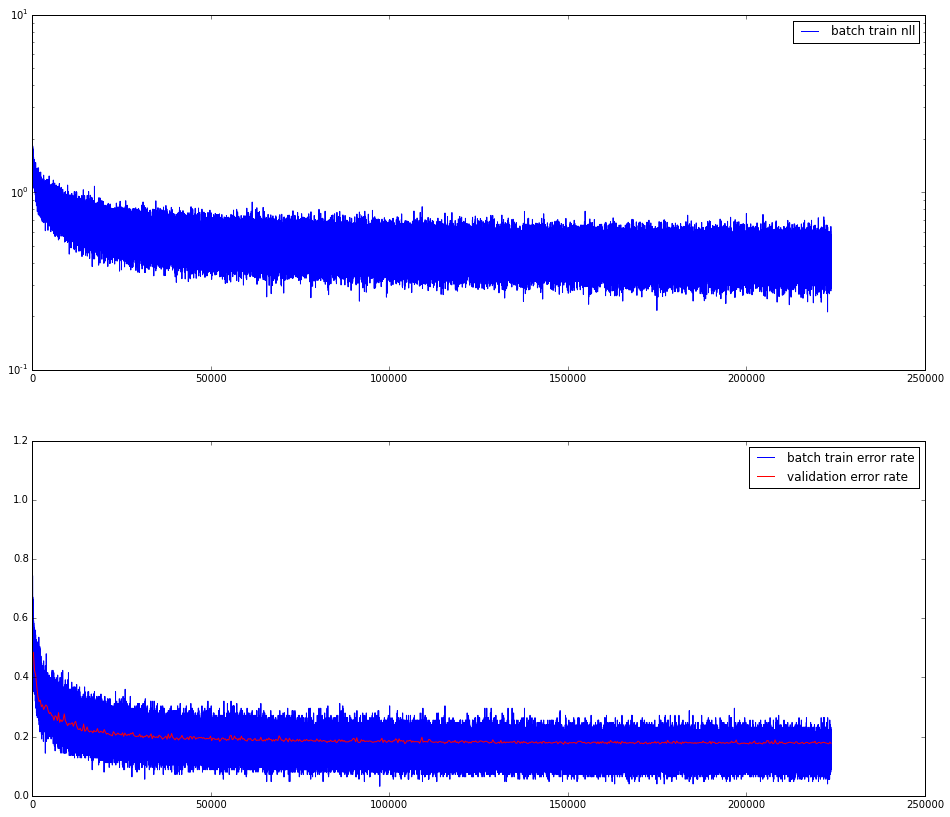

In [11]:
fo = open('results4', 'w')

print "Setting network parameters from after epoch %d" %(best_params_epoch)
load_parameters(best_params)

countError = compute_error_rate_with_write(cifar10_testt_stream, fo)
print "Success rate is %f%%" %(100.0-countError*100.0,)
print "Error rate is %f%%" %(countError*100.0,)

figure(figsize=(16,14))

subplot(2,1,1)
train_nll_a = np.array(train_nll)
semilogy(train_nll_a[:,0], train_nll_a[:,1], label='batch train nll')
legend()

subplot(2,1,2)
train_erros_a = np.array(train_erros)
plot(train_erros_a[:,0], train_erros_a[:,1], label='batch train error rate')
validation_errors_a = np.array(validation_errors)
plot(validation_errors_a[:,0], validation_errors_a[:,1], label='validation error rate', color='r')
ylim(0,1.2)
legend()

fo.close()